In [1]:
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.model_selection import cross_val_score

In [2]:
path_train = './CH22_Demand_XY_Train.csv'
train = pd.read_csv(path_train)

In [3]:
train

,DateTime,X1,X2,X3,X4,Y
0,2022-01-01 00:00:00,2.186333,13.76,0.0663,0.1547,521163.83540
1,2022-01-01 00:10:00,2.138000,13.90,0.0910,0.1105,449066.62018
2,2022-01-01 00:20:00,2.104333,13.90,0.0806,0.1300,437394.72159
3,2022-01-01 00:30:00,2.040333,14.00,0.1183,0.1248,422107.63292
4,2022-01-01 00:40:00,1.973667,14.14,0.0624,0.1105,406923.83540
...,...,...,...,...,...,...
41927,2022-10-19 03:50:00,5.856667,17.66,0.1092,0.1391,365929.91028
41928,2022-10-19 04:00:00,5.860000,17.66,0.1183,0.1495,368822.51417
41929,2022-10-19 04:10:00,5.846667,17.68,0.1001,0.1976,373857.78769
41930,2022-10-19 04:20:00,5.856667,17.66,0.1183,0.1391,373536.38739


In [4]:
train.describe()

,X1,X2,X3,X4,Y
count,41932.000000,41932.000000,41932.000000,41932.000000,41932.000000
mean,6.520033,12.528736,261.430021,106.260820,504322.861242
std,1.982503,3.212579,363.704356,169.071949,121948.222159
min,1.082333,1.268000,0.005200,0.024700,178443.835400
25%,4.960000,10.464000,0.085800,0.163800,401060.773570
50%,6.640000,12.870000,18.219500,15.860000,506391.834490
75%,7.983333,15.260000,473.590000,146.250000,588871.076658
max,13.336667,17.760000,1511.900000,1216.800000,829691.717040


### Data Prepartion

In [5]:
# parsing to datetime
train.DateTime = pd.to_datetime(train.DateTime)

In [6]:
train.dtypes

DateTime    datetime64[ns]
X1                 float64
X2                 float64
X3                 float64
X4                 float64
Y                  float64
dtype: object

In [7]:
train.set_index(train['DateTime'],inplace = True)

In [8]:
# DateTime changed into the index
train_idx = train[['X1', 'X2', 'X3', 'X4', 'Y']]

### Splitting Train and Test

In [9]:
actual_arr = np.array(train_idx['Y'])
train_idx = train_idx.drop('Y', axis=1)
train_idx_arr = np.array(train_idx)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train_idx_arr, actual_arr, test_size = 0.25, random_state = 0)

In [11]:
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (31449, 4)
y_train Shape: (31449,)
X_test Shape: (10483, 4)
y_test Shape: (10483,)


### Random Forest

In [12]:
rf = rfr(n_estimators = 100, random_state = 0)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [13]:
rf_pred = rf.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_pred)
r2 = r2_score(y_test, rf_pred)

accuracies_rf = cross_val_score(estimator = rf, X = X_train, y = y_train, cv = 10)
print('Accuracy(mean):', accuracies_rf.mean())
print('Accuracy(std):', accuracies_rf.std())

print('Mean Squared Error:', rf_mse, 'degrees.')
print('Root Mean Squared Error:', np.sqrt(rf_mse))
print('R-squared:', r2)

Accuracy(mean): 0.44903477739752684
Accuracy(std): 0.008997314078882214
Mean Squared Error: 8016916538.706596 degrees.
Root Mean Squared Error: 89537.23548729096
R-squared: 0.45456268591890747


### Use CV to find the best parameters

In [14]:
rf2 = rfr()

n_estimators = [5,20,50,100]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
min_samples_split = [2, 6, 10]
min_samples_leaf = [1, 3, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

rf_cv = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 100, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)

rf_cv.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=42, verbose=2)

In [15]:
print ('Best Parameters: ', rf_cv.best_params_)

Best Parameters:  {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': True}


### Apply the best param

In [16]:
bp_rf = rfr(n_estimators = 100, min_samples_split = 6, min_samples_leaf = 1, max_features = 'auto', max_depth = 110, bootstrap = True)
bp_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=110, min_samples_split=6)

In [17]:
bp_rf_pred = bp_rf.predict(X_test)

bp_rf_mse = mean_squared_error(y_test, bp_rf_pred)
bp_r2 = r2_score(y_test, bp_rf_pred)

accuracies_bp = cross_val_score(estimator = bp_rf, X = X_train, y = y_train, cv = 10)
print('Accuracy(mean):', accuracies_bp.mean())
print('Accuracy(std):',accuracies_bp.std())

print('Mean Squared Error:', bp_rf_mse, 'degrees.')
print('Root Mean Squared Error:', np.sqrt(bp_rf_mse))
print('R-squared:', bp_r2)

Accuracy(mean): 0.448346040031233
Accuracy(std): 0.008951512649360366
Mean Squared Error: 8026435099.57048 degrees.
Root Mean Squared Error: 89590.37392248388
R-squared: 0.45391508303487493


### Find important features

In [18]:
rf.feature_importances_

array([0.4205205 , 0.25944122, 0.17621819, 0.14382009])

<BarContainer object of 4 artists>

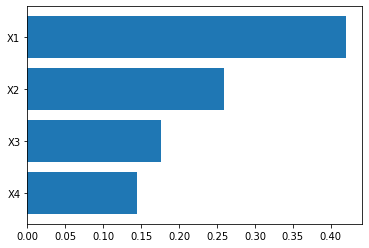

In [19]:
order = rf.feature_importances_.argsort()
plt.barh(train_idx.columns[order], rf.feature_importances_[order])

### Only with the two most important inputs

In [20]:
Xs = list(train_idx.columns)

rf_impt = rfr(n_estimators = 100, min_samples_split = 6, min_samples_leaf = 1, max_features = 'auto', max_depth = 110, bootstrap = True)
impt = [Xs.index('X1'), Xs.index('X2')]
train_important = X_train[:, impt]
test_important = X_test[:, impt]

In [21]:
rf_impt.fit(train_important, y_train)

RandomForestRegressor(max_depth=110, min_samples_split=6)

In [22]:
pred_impt = rf_impt.predict(test_important)

rf_mse = mean_squared_error(y_test, pred_impt)
r2 = r2_score(y_test, pred_impt)

accuracies_impt = cross_val_score(estimator = rf_impt, X = X_train, y = y_train, cv = 10)
print('Accuracy(mean):', accuracies_impt.mean())
print('Accuracy(std):', accuracies_impt.std())

print('Mean Squared Error:', rf_mse, 'degrees.')
print('Root Mean Squared Error:', np.sqrt(rf_mse))
print('R-squared:', r2)

Accuracy(mean): 0.44846903481130845
Accuracy(std): 0.010747125121992544
Mean Squared Error: 11177901449.5455 degrees.
Root Mean Squared Error: 105725.59505410929
R-squared: 0.23950255509496943


# Apply to test dataset

In [23]:
path_test = './CH22_Demand_raw_X_Test.csv'
test = pd.read_csv(path_test)

In [24]:
test

,DateTime,X1,X2,X3,X4
0,2022-10-19 04:40:00,5.943333,17.72,0.1001,0.1690
1,2022-10-19 04:50:00,5.990000,17.68,0.1092,0.1872
2,2022-10-19 05:00:00,5.993333,17.66,0.1235,0.1014
3,2022-10-19 05:10:00,6.000000,17.68,0.0949,0.1690
4,2022-10-19 05:20:00,6.013333,17.68,0.1326,0.1300
...,...,...,...,...,...
10479,2022-12-30 23:10:00,2.336667,13.48,0.0520,0.1248
10480,2022-12-30 23:20:00,2.315667,13.52,0.0663,0.1209
10481,2022-12-30 23:30:00,2.300000,13.56,0.1092,0.0962
10482,2022-12-30 23:40:00,2.252667,13.60,0.0858,0.1157


In [25]:
test.describe()

,X1,X2,X3,X4
count,10484.000000,10484.000000,10484.000000,10484.000000
mean,5.270002,13.144527,141.817033,62.642190
std,1.348219,2.604375,223.973160,120.452849
min,1.513333,4.206000,0.009100,0.014300
25%,4.389167,11.412000,0.071500,0.149500
50%,5.376667,13.340000,0.109200,0.211900
75%,6.386667,15.340000,235.592500,80.125500
max,8.853333,17.960000,1093.300000,1084.200000


### Data Prepartion

In [26]:
# parsing to datetime
test.DateTime = pd.to_datetime(test.DateTime)

In [27]:
test.dtypes

DateTime    datetime64[ns]
X1                 float64
X2                 float64
X3                 float64
X4                 float64
dtype: object

In [37]:
test = test.set_index(test['DateTime']).resample('60min').mean()

In [38]:
# DateTime changed into the index
test_idx = test[['X1', 'X2', 'X3', 'X4']]

In [39]:
test_idx['yhat'] = 0

In [40]:
final = test_idx

### Splitting Train and Test

In [41]:
test_arr = np.array(test_idx['yhat'])
test_idx = test_idx.drop('yhat', axis=1)
test_idx_arr = np.array(test_idx)

In [42]:
X_test, y_test = test_idx_arr, test_arr

In [43]:
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

X_test Shape: (1748, 4)
y_test Shape: (1748,)


### Random Forest

### Apply the best param

In [44]:
bp_rf_pred = bp_rf.predict(X_test)
final['yhat'] = bp_rf_pred
final

,X1,X2,X3,X4,yhat
DateTime,,,,,
2022-10-19 04:00:00,5.966667,17.700000,0.104650,0.178100,432583.378576
2022-10-19 05:00:00,6.057778,17.686667,0.110067,0.147117,463387.338268
2022-10-19 06:00:00,6.077778,17.630000,0.100967,0.158167,477342.055803
2022-10-19 07:00:00,6.026111,17.483333,18.673850,15.738017,455361.319065
2022-10-19 08:00:00,6.131111,17.153333,42.345333,36.012167,411062.530027
...,...,...,...,...,...
2022-12-30 19:00:00,3.151111,11.481333,0.067600,0.132600,331318.186084
2022-12-30 20:00:00,3.013889,11.798000,0.068467,0.136500,340017.260962
2022-12-30 21:00:00,2.670556,12.935000,0.095117,0.127833,376929.336001


In [46]:
final.describe()

,X1,X2,X3,X4,yhat
count,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000
mean,5.270267,13.146264,141.762985,62.618367,477197.197901
std,1.344259,2.589220,218.748267,116.728689,71321.238381
min,1.553611,4.413333,0.036617,0.052000,294761.092612
25%,4.402083,11.491333,0.072313,0.154267,432651.596577
50%,5.386389,13.339000,0.108767,0.208000,479914.535847
75%,6.368611,15.317500,250.645417,87.191542,517318.069978
max,8.766111,17.950000,1011.833333,969.020000,694587.777744
